# Gaussian process Mathematics

In this notebook I am presenting how we can code a Gaussian Process from scratch.
This is not yet a full Bayesian Optimization loop, but it showcases the most common surrogate model of the BO, the Gaussian Process Regression.

Gaussian processes leverage the properties of the Multivariate Normal Distribution.
The most important property that we can leverage is the marginalization property. If $P(a,b)\sim\text{MVN}$, then $P(a) = \int_b P(a,b)db \sim \text{MVN}$.

Suppose that we have the familiar problem of $f(x)=w^\top x + \varepsilon$, $\varepsilon \sim N(0,1)$, with data $D=\{(x_1,y_1),(x_2,y_2),\dots, (x_n, y_n)\}$.
The aim is to model the whole *predictive distribution* of the target $y$ and forget the weights $w$ (integrate them out).

We can find $w$ in two main ways.

1. **Maximum Likelihood Estimation:** "If we choose a particular $w$ what is the probability that this $w$ paired with this input $x_i$ gives rise to this particular (the one we observe) $y_i$ target?"
   $$\max P(D|w)=\prod_{i=1}^n p(y_i|x_i,w)$$
2. **Maximum a posteriori Estimation**: Given that we have this particular set of data $D$, what is the most likely set of parameters that could generate those datapoints?
   $$P(w|D) = \frac{p(D|w)p(w)}{p(D)}$$

This is all known ways to perform estimation of parameters in a linear model. Gaussian processes go a step further by saying that, the whole **reason** that we are searching for the $w$ is to use them to make predictions, or $y^{\text{new}}=w^\top x^{\text{new}}$.
We use $D$ -> $w$ -> $y^{\text{new}}$. So instead of trying to model the distribution of the $w$, why don't me go directly to modelling the distribution of the new points?

In order to make predictions **we have to have** a model, **but** we can **marginalise** it out, as $y$ depends on $w$ and $w$ depends on $D$.
$$
P(y|x,D) = \int_w P(y|x,D,w) dw =  \int_w P(y|x,w) p(w|D)dw = \int_w p(y|x,w)\frac{p(D|w)p(w)}{Z} dw
$$


If we make the **critical assumption** of setting $p(w) \sim N$ (prior), then by the convenient properties of the multivariate Normal distribution the output, is a Gaussian!

We can make predictions about a new $y$ without learning any specific parameter vector $w$. No commitment.
And not only that! We don't only have a prediction for $y^*$, we also have a *confidence interval* around it to quantify uncertainty.

**Question**. In the regular linear regression with OLS, we also get confidence intervals. Why bother going through all this to end up on the same conclusion?
**Answer**: Not at all the same conclusion. The CI that OLS produces is a flat $\pm \lambda$ that depends on the uncertainty $\sigma$ of $\varepsilon$. This is the uncertainty *of the distribution itself*. In other words, in OLS we are only modelling the mean and constructing the CIs so we can have some estimate of upper and lower bound. In GPs we are modelling the whole distribution to begin with and the CIs come "for free".
*The GP CIs are a more accurate and easier to interpret adaptation of the OLS CIs!*
(Hint: Look on Google at what happens to the CIs on the tails of prediction plots.)

We can take this one step further!
We see that by starting with reasonable assumptions and by making logical steps, we end up having a MVN distribution as the distribution of our data.
Hence, we can write that:
$$
p(y|x,D) \sim \text{MVN}(\mu, \Sigma)
$$
And now the goal has changed, from estimating $\hat{w}$ to estimating $\hat{\mu}$ and $\hat{\Sigma}$. In fact we can always assume that $\hat{\mu}=0$ as we can always centre our data and back the bias at the end.

### Conclusion
In the end what we get is **Kernel Regression** + **Variance**.
The selling price of my house will be $K_*^\top K^{-1} y$  **+** There is a good change that it will be between $K_*^\top K^{-1} y \pm K_{**}K^{-1}K_*$
We managed to quantify uncertainty through the Bayesian Prior Assumption.

The following is an implementation in code of a simple 1D Gaussian Process Regression.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
np.random.seed(42)

- In theory (Mathematics) we evaluate the function in **infinite** datapoints.
- In practive (Computer Science) we evaluate in as many as possible to get an good enough result.

Here we will use 50 points on the range [-5,5], so this range is our **test** set. The range were we want to estimate an underlying function.

In [22]:
N = 50 # axis points
x_test = np.linspace(-5, 5, N)

Let's asume that we have a function like $f(x) = \sin(0.9x)$ as the ground truth (a way to get our $y$'s).

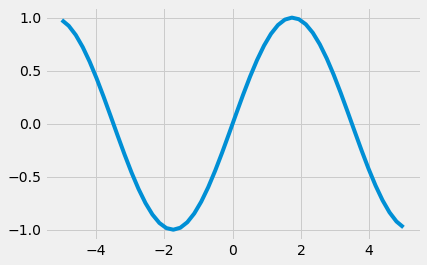

In [23]:
f = lambda x: np.sin(0.9*x)
plt.plot(x_test, f(x_test))

Suppose that we want to define a GP with a basic RBF kernel.
The kernel is defined by the following function.

In [24]:
def kernel(x1, x2, gamma=5):
    rbf = lambda x, y: np.exp(
        - gamma * np.linalg.norm([x - y], 2)**2
    )
    K = np.empty((len(x1), len(x2)))
    for i, a in enumerate(x1):
        for j, b in enumerate(x2):
            K[i, j] = rbf(a, b)
    return K

By assuming a *normal* prior (a GP in its most basic form) with an RBF kernel we can draw 10 samples from that prior as such.

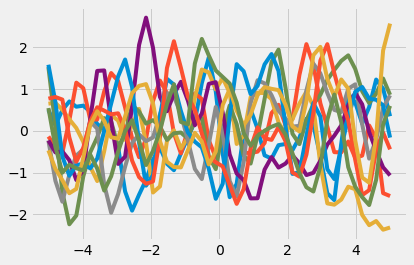

In [25]:
K_ss = kernel(x_test, x_test) # (50 x 50)
L_ss = np.linalg.cholesky(K_ss) # (50 x 50)
n = 10 # prior samples
f_prior = L_ss @ np.random.normal(size=(N, n)) # (50 x 10)

plt.plot(x_test, f_prior)
plt.show()

We go out in the real world and we observe the function $f$ in 15 training points.

In [26]:
n_train = 15
x_train = np.random.uniform(-5., 5., n_train)
y_train = f(x_train)

We know from the theory that give some train and some test points, we can estimate the underlying true function by computing a new normal distribution of the following form:


$$
\begin{align*}
\hat{y} \vert D = \mathcal{N}(K_*^\top K^{-1} y,~~~ K_{**} - K_*^\top K^{-1} K_*)
\end{align*}
$$

We thus only have to compute these two terms, the mean and the covariance matrix.

In [27]:
K = kernel(x_train, x_train)
K_s = kernel(x_train, x_test)
K_ss = kernel(x_test, x_test)
Normal = np.random.normal(size=(N, n))

In [28]:
# This can get slow because of the np.linalg.inv(...) function.
mu = (K_s.T @ np.linalg.inv(K) @ y_train).reshape(-1,1)
Sigma = K_ss - K_s.T @ np.linalg.inv(K) @ K_s
L_Sigma = np.linalg.cholesky(Sigma)
f_post = mu + L_Sigma @ Normal

In [29]:
# # This is much faster as it only uses the Cholesky decomposition and elimination to calculate the answer.
# L = np.linalg.cholesky(K)
# m = np.linalg.solve(L, y_train)
# alpha = np.linalg.solve(L.T, m)

# mu = (K_s.T @ alpha).reshape(-1,1) # (50 x 1)

# beta = np.linalg.solve(K, K_s)
# cov = K_ss - K_s.T @ beta # (50 x 50)
# L_cov = np.linalg.cholesky(cov)
# f_post_fast = mu + L_cov @ Normal

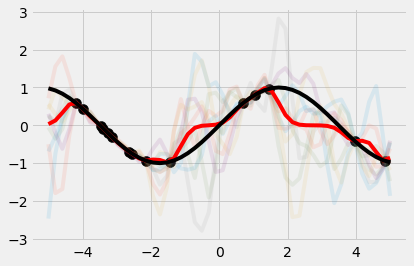

In [30]:
plt.plot(x_test, f_post, alpha=.1)
plt.plot(x_test, mu, color="red")
plt.scatter(x_train, y_train, color="black", s=100)
plt.plot(x_test, f(x_test), color="black")
plt.show()